# Gradient Boost Regression Tree

Gradient Boost Regression Trees (GBRT) are an ensemble learning technique that successivley trains new weak learners which are added to the ensemble to make up for errors in the previous ensemble.  The term "Gradient Boost" is derived from the structure of the algorithm to update the ensemble, which looks like gradient descent in the functional space.

Suppose we are given a task to predict an output variable $y$ from a set of training data $x$.  Let $F_{m}$ denote the predicted output from our ensemble predictor at step $m$ of the GBRT.  As $F_{m}$ is an imperfect predictor, the goal of GBRT is to add a new learner to the ensemble to try and reduce the prediction error associated with $F_{m}$.  The ensemble at step $m+1$ can be expressed as:
$$
F_{m+1} = F_{m} + \arg\min_{h}\Big[ \frac{1}{n}\sum_{i=1}^{n} L \big(y_{i},F_{m}(x_{i}) + h(x_{i})\big) \Big]
$$

where $L()$ is the loss function.  Instead of optimizing the rightmost term completely, the nonlinear loss function can be approximated by a first order Taylor Expansion (as L is assumed to be differentiable):
$$
\begin{equation}
L \big(y_{i},F_{m}(x_{i}) + h_{m}(x_{i})\big) \approx L \big(y_{i},F_{m}(x_{i}))\big) +  h(x_{i})\frac{dL(y_{i},F(x_{i}))}{dF(x_{i})}\Bigg|_{F_{m}(x_{i})}
\end{equation}
$$

Let
$$
\begin{equation}
g_{i} = \frac{dL(y_{i},F(x_{i}))}{dF(x_{i})}\Bigg|_{F_{m}(x_{i})}
\end{equation}
$$

Noting that the first term on the RHS of the Taylor Expansion doesn't affect the choice of $h$, we have:
$$
\begin{equation}
\arg\min_{h}\Big[ \frac{1}{n}\sum_{i=1}^{n} L \big(y_{i},F_{m}(x_{i}) + h(x_{i})\big) \Big] \approx \arg\min_{h} \Bigg[ \frac{1}{n}\sum_{i=1}^{n} h(x_{i})g_{i}\Bigg] 
\end{equation}
$$

The quantity on the RHS will be minimized if $h$ is fit to predict $-\alpha g_{i}$ where $\alpha$ is positive and arbitrarily large.  In practice, $\alpha$ should be kept relatively small so that the first order Taylor Expansion is a good approximation.  If the loss function is the squared error, then it is straightforward to show that $g_{i}$ is the residual $r_{i} = y_{i} - F_{m}(x_{i})$.  Choosing $\alpha$ small implies only small improvements will be made to the ensemble at each iteration of the ensemble improvement.  Thus the ensemble iteration algorithm is:
$$
F_{m+1} = F_{m} + \alpha h_{m}
$$

where $h_{m}$ is fit to predict $-g_{i}$ which is equal to the residual error of the ensemble at step $m$.

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

Text(0, 0.5, 'y')

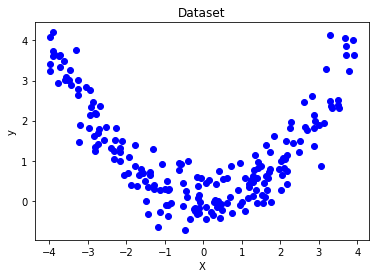

In [2]:
#generate nonlinear regression data
num_points = 200
x_min = -4
x_max = 4
c = 0.25
X = np.sort(np.random.uniform(x_min, x_max, num_points)).reshape(-1,1)

#statistics for noise
e_mean = 0
e_var = 0.5
e = np.random.normal(e_mean, e_var, num_points).reshape(-1,1)

#generate target data
y = (c * X ** 2 + e).flatten()

#plot data
plt.plot(X,y,'bo')
plt.title('Dataset')
plt.xlabel('X')
plt.ylabel('y')

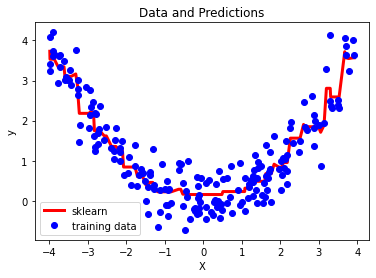

In [3]:
#GBRT sklearn

n = 50  #number of estimators
alpha = 0.1 #learning rate
m_depth = 2 #max_depth of decision trees

#sklearn GBRT
gbrt = GradientBoostingRegressor(max_depth=m_depth, n_estimators=n, learning_rate=alpha)
gbrt.fit(X.reshape(-1,1),y)

#plot against training set
y_pred = gbrt.predict(X)
plt.plot(X,y_pred,'r',label='sklearn',linewidth=3)
plt.plot(X,y,'bo',label='training data')
plt.title('Data and Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

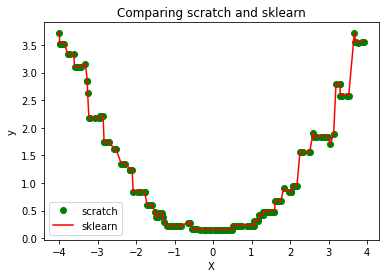

In [4]:
#GBRT from scratch

h = []  #list of estimators
_y = y  #placeholder for residuals

#train
for i in range(0,n):
    #train a weak learner on last residual
    _h = DecisionTreeRegressor(max_depth=m_depth).fit(X,_y)
    h.append(_h)
    #update residual with learning rate
    _y = _y - alpha*_h.predict(X)
    
#predict
y_pred_scratch = sum(tree.predict(X) for tree in h) * alpha
    
plt.plot(X,y_pred_scratch,'go',label='scratch')
plt.plot(X,y_pred,'r',label='sklearn')
plt.title('Comparing scratch and sklearn')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()